# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- changer les ratios pixels centimeters
- recul du robot en local a mettre en fonction des capteurs
- camera qui prend images toutes les secondes

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math
import cv2
import asyncio

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
# Robot's speed for a given task 
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30
SPEED_BACKWARD = 50

SPEED_CORRECTION = 1 
SPEED_CONSTANT = 18.1818

# Proximity sensors thresholds
PROX_1_THRESHOLD = 4000
PROX_2_THRESHOLD = 2000
PROX_3_THRESHOLD = 1000
THRESHOLD_PROX_SENSOR = 20

# States of our finite-state-machine
ROTATION_STATE = 1
TRANSLATION_STATE = 2
CAMERA_STATE = 3
LOCAL_AVOIDANCE_STATE = 4

# Accuracy threshold when the robot thinks its arrived at a intermediate goal
TRANS_ACCURACY = 0.8
ROT_ACCURACY = 0.1
CHECK_ANGLE = math.pi / 2.0

# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Open camera
cap = cv2.VideoCapture(0)
if cap.isOpened() == False:
    print("Erreur: Impossible d'ouvrir la webcam.")

time.sleep(2)
ret, frame = cap.read()
    
if ret == False:
    print("Erreur: Impossible de capturer l'image.")


In [6]:
# Set the camera chec
async def check_camera():
    while cap.isOpened() and camera_check_enabled:
        # Use camera to check direction and location
        ret, frame = cap.read()
        robot_centroid, robot_direction = vision.vision_robot(frame)
        
        # Update Kalman filter with camera measurements
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        
        await client.sleep(0.5)  

In [7]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [8]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([PROX_1_THRESHOLD, PROX_2_THRESHOLD, PROX_3_THRESHOLD, 
                                                   PROX_2_THRESHOLD, PROX_1_THRESHOLD])) 
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

### Step 1: Check the connexion between the Thymio and the computer

In [9]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(817, 537), (1253, 537), (1253, 0), (817, 0)]]
Centroid de la goal area : [1631.  572.]
Vecteur direction du robot : 99 -4
Centroid du robot : [598 322]


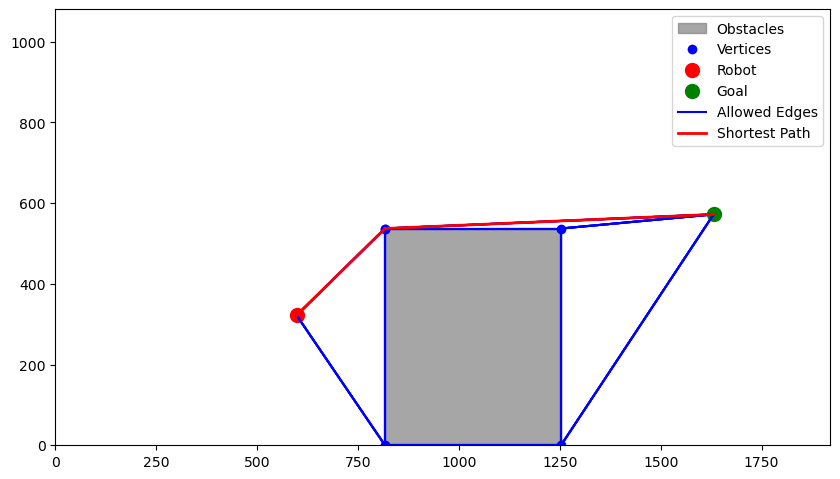

In [10]:
ret, frame = cap.read()

# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal(frame)
robot_centroid, robot_direction = vision.vision_robot(frame)

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot(frame)

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

### Step 3: Control the motors and check the robot position with an extended Kalman filter and use local avoidance if necessary

Iteration: 1
Kalman:  x:  32.0 , y:  17.0 , angle:  -0.04038207556449991
Rotation state:
Robot angle:  [-0.04038208] , Goal angle:  [0.78539816] , Rotation to achieve:  [0.82578024]
Iteration: 2
Kalman:  x:  32.0 , y:  17.0 , angle:  -0.04038207556449991
Rotation state:
Robot angle:  [-0.04038208] , Goal angle:  [0.78539816] , Rotation to achieve:  [0.82578024]
Iteration: 3
Kalman:  x:  32.003488296979015 , y:  16.99985905870792 , angle:  -0.020617700822898467
Rotation state:
Robot angle:  [-0.0206177] , Goal angle:  [0.7855494] , Rotation to achieve:  [0.8061671]
Iteration: 4
Kalman:  x:  32.00397358639035 , y:  16.999850172561132 , angle:  0.03638237930334745
Rotation state:
Robot angle:  [0.03638238] , Goal angle:  [0.78557] , Rotation to achieve:  [0.74918762]
Iteration: 5
Kalman:  x:  31.997054243796832 , y:  16.99966418502097 , angle:  0.11579642460832743
Rotation state:
Robot angle:  [0.11579642] , Goal angle:  [0.78528943] , Rotation to achieve:  [0.66949301]
Iteration: 6
Kalma

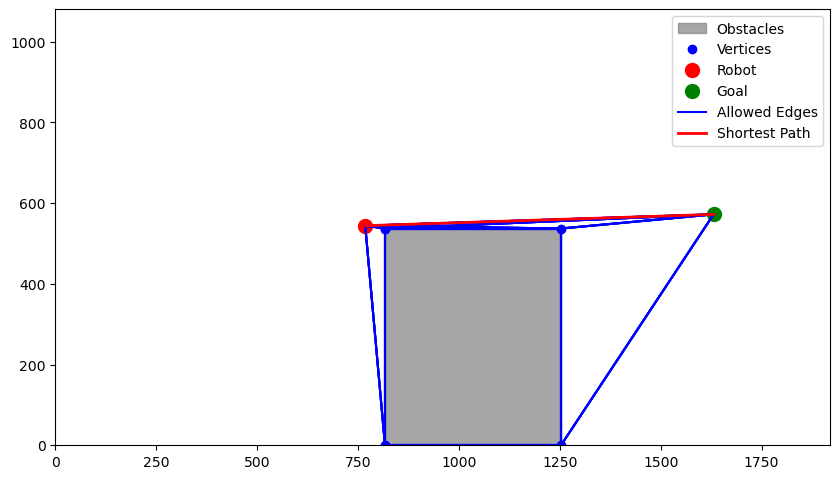

centroid camera:  (41, 29)
glob nav path : [(88, 30)]
Iteration: 33
Kalman:  x:  40.99993559239273 , y:  29.00057163836283 , angle:  0.812306071252547
Rotation state:
Robot angle:  [0.81230607] , Goal angle:  [0.0212612] , Rotation to achieve:  [-0.79104487]
Iteration: 34
Kalman:  x:  41.76265396287558 , y:  29.80547386719022 , angle:  0.8069318091466513
Rotation state:
Robot angle:  [0.80693181] , Goal angle:  [0.0042071] , Rotation to achieve:  [-0.80272471]
Iteration: 35
Kalman:  x:  42.27778240442291 , y:  30.352074286403163 , angle:  0.7820603908153891
Local avoidance state:
Iteration: 36
Kalman:  x:  45.14921266360316 , y:  33.246724617973165 , angle:  0.09568067405489764
Camera state:
Vecteur direction du robot : 88 48
Centroid du robot : [652 451]


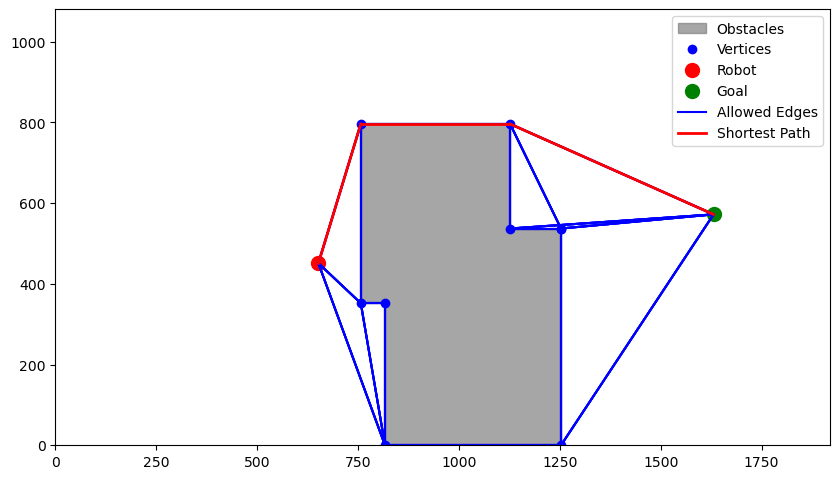

centroid camera:  (35, 24)
glob nav path : [(40, 43), (60, 43), (88, 30)]
Iteration: 37
Kalman:  x:  35.00141782939987 , y:  23.999173236633503 , angle:  0.4981733679197931
Rotation state:
Robot angle:  [0.49817337] , Goal angle:  [1.31355311] , Rotation to achieve:  [0.81537974]
Iteration: 38
Kalman:  x:  34.193131174039884 , y:  23.559560977404793 , angle:  0.48399228527205834
Rotation state:
Robot angle:  [0.48399229] , Goal angle:  [1.28053216] , Rotation to achieve:  [0.79653988]
Iteration: 39
Kalman:  x:  33.51664647696534 , y:  23.212541984452567 , angle:  0.5009614781776169
Rotation state:
Robot angle:  [0.50096148] , Goal angle:  [1.25416979] , Rotation to achieve:  [0.75320831]
Iteration: 40
Kalman:  x:  33.22168475245546 , y:  23.056129604917167 , angle:  0.5585639087973239
Rotation state:
Robot angle:  [0.55856391] , Goal angle:  [1.24317471] , Rotation to achieve:  [0.6846108]
Iteration: 41
Kalman:  x:  33.11472342278476 , y:  22.989059484545578 , angle:  0.639649867826794

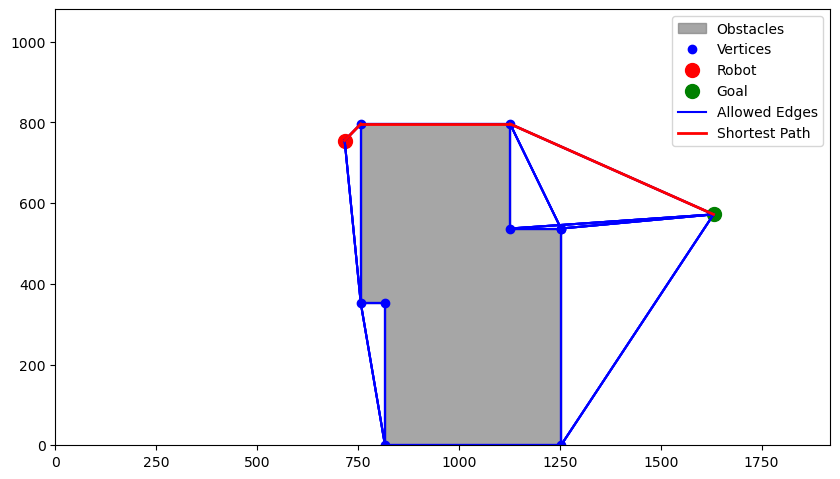

centroid camera:  (38, 40)
glob nav path : [(40, 43), (60, 43), (88, 30)]
Iteration: 72
Kalman:  x:  37.99989578608068 , y:  40.00052923063137 , angle:  1.2838340959814367
Rotation state:
Robot angle:  [1.2838341] , Goal angle:  [0.98268824] , Rotation to achieve:  [-0.30114585]
Iteration: 73
Kalman:  x:  38.227050016367095 , y:  40.770248035892116 , angle:  1.2884552611371334
Rotation state:
Robot angle:  [1.28845526] , Goal angle:  [0.89902995] , Rotation to achieve:  [-0.38942531]
Iteration: 74
Kalman:  x:  38.365829130883654 , y:  41.26837423166795 , angle:  1.270858117618921
Rotation state:
Robot angle:  [1.27085812] , Goal angle:  [0.81434456] , Rotation to achieve:  [-0.45651356]
Iteration: 75
Kalman:  x:  38.41552209749605 , y:  41.4386121622681 , angle:  1.2109096395990933
Rotation state:
Robot angle:  [1.21090964] , Goal angle:  [0.77805848] , Rotation to achieve:  [-0.43285116]
Iteration: 76
Kalman:  x:  38.432068134791706 , y:  41.48194641246383 , angle:  1.1287525891954815

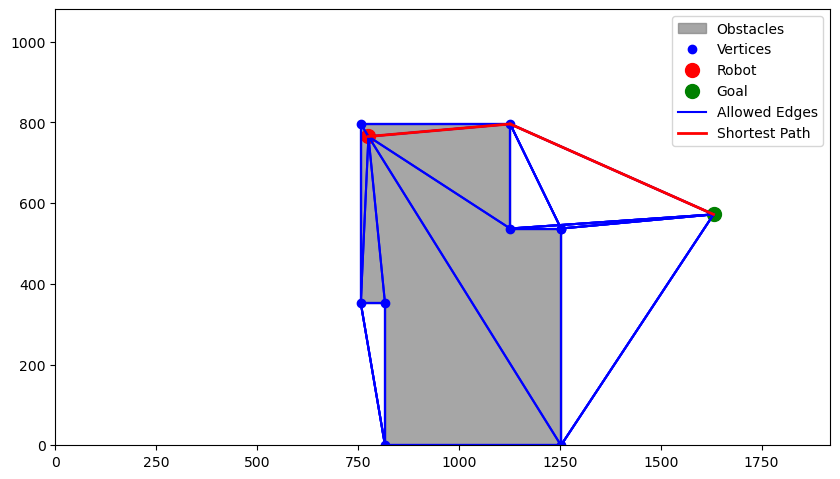

centroid camera:  (41, 41)
glob nav path : [(60, 43), (88, 30)]
Iteration: 86
Kalman:  x:  40.99420408944297 , y:  41.004211036954445 , angle:  0.630933036867829
Rotation state:
Robot angle:  [0.63093304] , Goal angle:  [0.10462605] , Rotation to achieve:  [-0.52630699]
Iteration: 87
Kalman:  x:  41.89656032948971 , y:  41.66338917814111 , angle:  0.6239283914046555
Rotation state:
Robot angle:  [0.62392839] , Goal angle:  [0.07369815] , Rotation to achieve:  [-0.55023024]
Iteration: 88
Kalman:  x:  42.55172522477112 , y:  42.13826212198158 , angle:  0.6130442771279234
Rotation state:
Robot angle:  [0.61304428] , Goal angle:  [0.04934805] , Rotation to achieve:  [-0.56369623]
Iteration: 89
Kalman:  x:  42.81838203579846 , y:  42.33482523870782 , angle:  0.564995318645398
Rotation state:
Robot angle:  [0.56499532] , Goal angle:  [0.038695] , Rotation to achieve:  [-0.52630032]
Iteration: 90
Kalman:  x:  42.91093096371009 , y:  42.39329624731027 , angle:  0.48993755275907935
Rotation sta

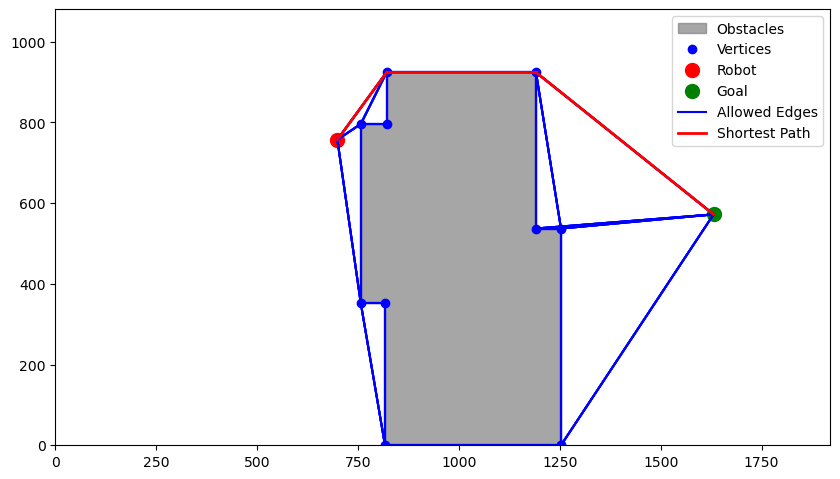

centroid camera:  (37, 40)
glob nav path : [(44, 49), (64, 49), (88, 30)]
Iteration: 107
Kalman:  x:  37.00047241463112 , y:  39.99997805279077 , angle:  -0.26317672914917106
Rotation state:
Robot angle:  [-0.26317673] , Goal angle:  [0.90978705] , Rotation to achieve:  [1.17296378]
Iteration: 108
Kalman:  x:  36.359853072694555 , y:  40.17257720860411 , angle:  -0.2653124057384273
Rotation state:
Robot angle:  [-0.26531241] , Goal angle:  [0.85737145] , Rotation to achieve:  [1.12268385]
Iteration: 109
Kalman:  x:  35.70305832905282 , y:  40.35477843295768 , angle:  -0.25225366760437207
Rotation state:
Robot angle:  [-0.25225367] , Goal angle:  [0.80595226] , Rotation to achieve:  [1.05820593]
Iteration: 110
Kalman:  x:  35.37477453228502 , y:  40.44456077479398 , angle:  -0.20320319522585578
Rotation state:
Robot angle:  [-0.2032032] , Goal angle:  [0.78133628] , Rotation to achieve:  [0.98453948]
Iteration: 111
Kalman:  x:  35.24889048388066 , y:  40.470935694055925 , angle:  -0.126

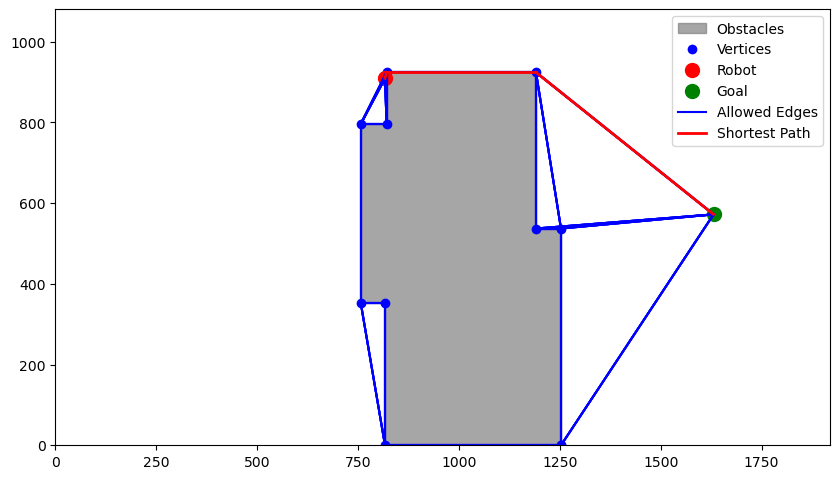

centroid camera:  (44, 49)
glob nav path : [(64, 49), (88, 30)]
Iteration: 136
Kalman:  x:  43.99981862159927 , y:  49.00040720621093 , angle:  0.7262229223381682
Rotation state:
Robot angle:  [0.72622292] , Goal angle:  [-2.03601259e-05] , Rotation to achieve:  [-0.72624328]
Iteration: 137
Kalman:  x:  44.718780003700346 , y:  49.63893819449505 , angle:  0.7230971973634233
Rotation state:
Robot angle:  [0.7230972] , Goal angle:  [-0.03312573] , Rotation to achieve:  [-0.75622293]
Iteration: 138
Kalman:  x:  45.24045515356553 , y:  50.1021184945955 , angle:  0.7135593614157693
Rotation state:
Robot angle:  [0.71355936] , Goal angle:  [-0.05868229] , Rotation to achieve:  [-0.77224165]
Iteration: 139
Kalman:  x:  45.46060454456965 , y:  50.30195232595245 , angle:  0.6666904946444555
Rotation state:
Robot angle:  [0.66669049] , Goal angle:  [-0.07011115] , Rotation to achieve:  [-0.73680165]
Iteration: 140
Kalman:  x:  45.53446595013982 , y:  50.36065158763512 , angle:  0.587434941448942

/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:93: RuntimeWarning: invalid value encountered in cast
  direction = (front_centroid - back_centroid).astype(int)
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:94: RuntimeWarning: invalid value encountered in cast
  midpoint = ((front_centroid + back_centroid) / 2).astype(int)


Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 

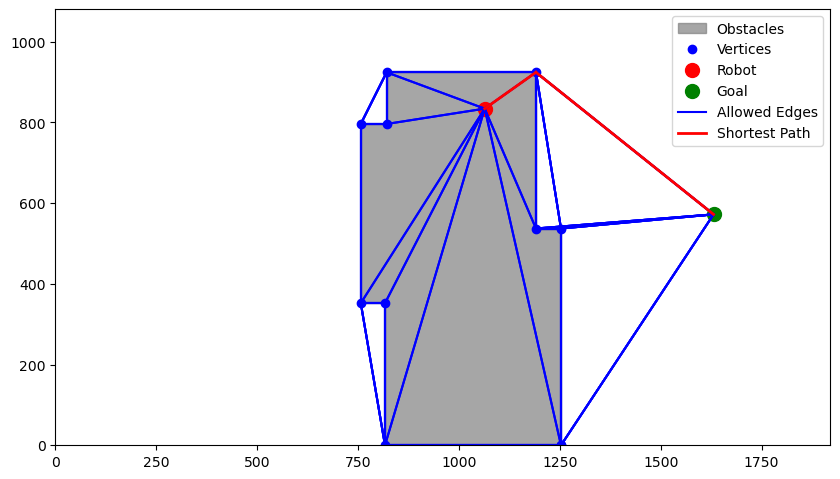

centroid camera:  (57, 45)
glob nav path : [(64, 49), (88, 30)]
Iteration: 168
Kalman:  x:  57.000802303976016 , y:  44.99990731398309 , angle:  -0.17188204360565315
Rotation state:
Robot angle:  [-0.17188204] , Goal angle:  [0.51920547] , Rotation to achieve:  [0.69108752]
Iteration: 169
Kalman:  x:  57.64803700415705 , y:  44.88754913682998 , angle:  -0.1823732842549203
Rotation state:
Robot angle:  [-0.18237328] , Goal angle:  [0.57456636] , Rotation to achieve:  [0.75693964]
Iteration: 170
Kalman:  x:  58.19839825641648 , y:  44.779586152031634 , angle:  -0.16566669414438046
Rotation state:
Robot angle:  [-0.16566669] , Goal angle:  [0.62891658] , Rotation to achieve:  [0.79458327]
Iteration: 171
Kalman:  x:  58.402621566945406 , y:  44.742740557575864 , angle:  -0.10586879463248891
Rotation state:
Robot angle:  [-0.10586879] , Goal angle:  [0.6502386] , Rotation to achieve:  [0.75610739]
Iteration: 172
Kalman:  x:  58.51879558852419 , y:  44.72940124015191 , angle:  -0.02087726162

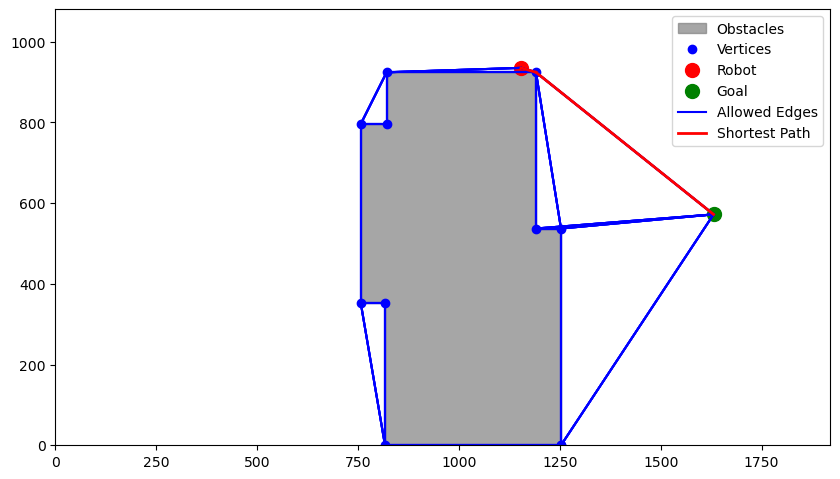

centroid camera:  (62, 50)
glob nav path : [(64, 49), (88, 30)]
Iteration: 191
Kalman:  x:  62.00000027793841 , y:  50.00064724408773 , angle:  0.6587976809012613
Rotation state:
Robot angle:  [0.65879768] , Goal angle:  [-0.46390653] , Rotation to achieve:  [-1.12270421]
Iteration: 192
Kalman:  x:  62.83788283980957 , y:  50.64930920306383 , angle:  0.6569481704562061
Rotation state:
Robot angle:  [0.65694817] , Goal angle:  [-0.95698415] , Rotation to achieve:  [-1.61393232]
Iteration: 193
Kalman:  x:  63.40048494413909 , y:  51.09049530964197 , angle:  0.6375896859045282
Rotation state:
Robot angle:  [0.63758969] , Goal angle:  [-1.29151042] , Rotation to achieve:  [-1.92910011]
Iteration: 194
Kalman:  x:  63.60559651260055 , y:  51.24695582695816 , angle:  0.5813862503843927
Rotation state:
Robot angle:  [0.58138625] , Goal angle:  [-1.39703847] , Rotation to achieve:  [-1.97842472]
Iteration: 195
Kalman:  x:  63.68568844383886 , y:  51.29958151010733 , angle:  0.501197956276396
Ro

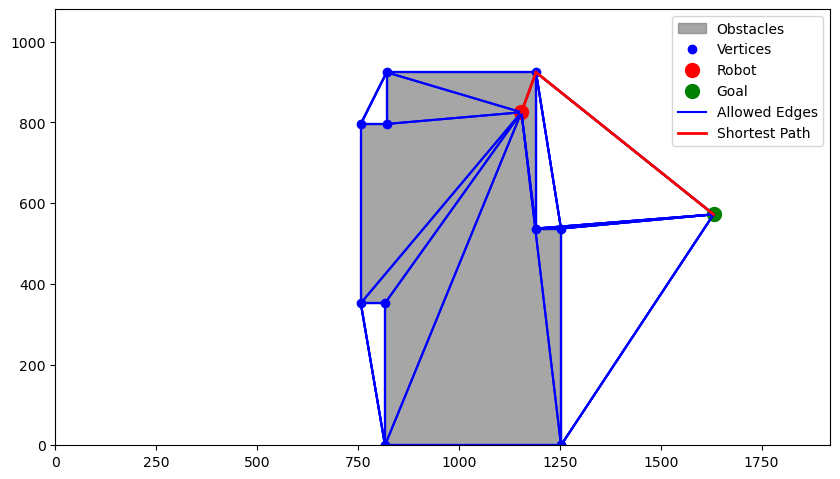

centroid camera:  (62, 44)
glob nav path : [(88, 30)]
Iteration: 222
Kalman:  x:  62.00028253813552 , y:  44.00121367279506 , angle:  -1.1034506653067602
Rotation state:
Robot angle:  [-1.10345067] , Goal angle:  [-0.49398209] , Rotation to achieve:  [0.60946857]
Iteration: 223
Kalman:  x:  62.173676896360625 , y:  43.65761633916942 , angle:  -1.1014193715746383
Rotation state:
Robot angle:  [-1.10141937] , Goal angle:  [-0.48644114] , Rotation to achieve:  [0.61497823]
Iteration: 224
Kalman:  x:  62.23545739118218 , y:  43.533256240475744 , angle:  -1.078271998741007
Rotation state:
Robot angle:  [-1.078272] , Goal angle:  [-0.48365605] , Rotation to achieve:  [0.59461595]
Iteration: 225
Kalman:  x:  62.26340717703824 , y:  43.47976886376493 , angle:  -1.017181808565597
Rotation state:
Robot angle:  [-1.01718181] , Goal angle:  [-0.48247355] , Rotation to achieve:  [0.53470826]
Iteration: 226
Kalman:  x:  62.272674649123026 , y:  43.46542991778452 , angle:  -0.9350816691223481
Rotatio

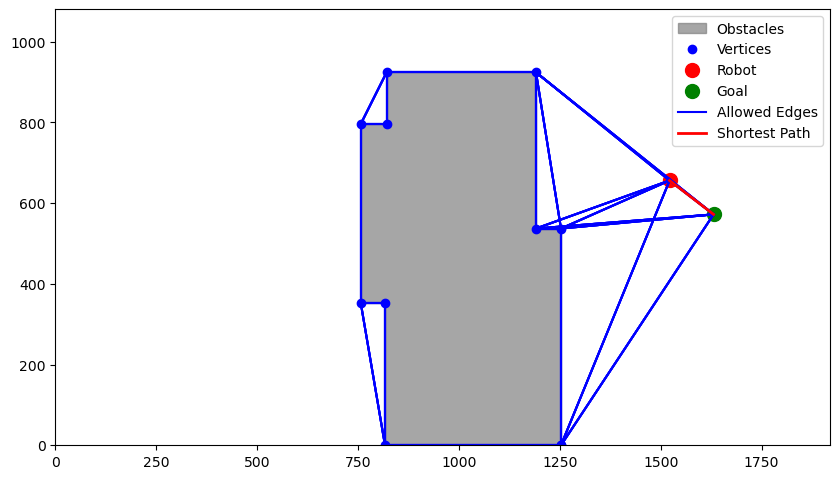

centroid camera:  (82, 35)
glob nav path : [(88, 30)]
Iteration: 262
Kalman:  x:  82.00071400585361 , y:  34.99980385935241 , angle:  -0.47120742216520844
Rotation state:
Robot angle:  [-0.47120742] , Goal angle:  [-0.69477751] , Rotation to achieve:  [-0.22357009]
Iteration: 263
Kalman:  x:  82.81942833666825 , y:  34.582675063679915 , angle:  -0.46909363137363486
Rotation state:
Robot angle:  [-0.46909363] , Goal angle:  [-0.72423502] , Rotation to achieve:  [-0.25514139]
Iteration: 264
Kalman:  x:  83.364590863918 , y:  34.31358540908595 , angle:  -0.4897664016358428
Rotation state:
Robot angle:  [-0.4897664] , Goal angle:  [-0.74945166] , Rotation to achieve:  [-0.25968525]
Iteration: 265
Kalman:  x:  83.55979783753796 , y:  34.2129339517073 , angle:  -0.5515784365255788
Rotation state:
Robot angle:  [-0.55157844] , Goal angle:  [-0.75913994] , Rotation to achieve:  [-0.2075615]
Iteration: 266
Kalman:  x:  83.66232073720529 , y:  34.14944988410633 , angle:  -0.6265053446446316
Rota

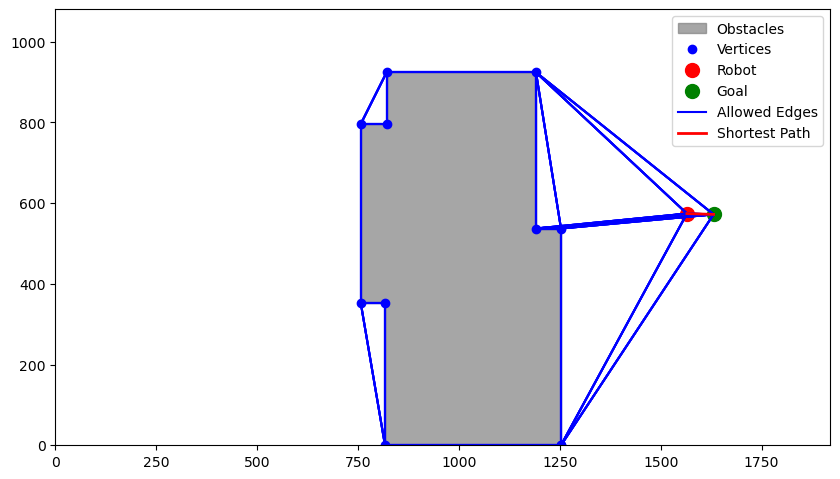

centroid camera:  (84, 31)
glob nav path : []
Iteration: 277
Thymio arrived in the goal area, congratulations!


In [11]:
# Initial state
global_state = ROTATION_STATE

# Receive all the informations from the vision and global navigation
intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])
robot_speed = [0.0,0.0]

# Initialize the Kalman filter
Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)

# Start the check_camera coroutine in the background
camera_task = asyncio.create_task(check_camera())

old_time = 0.0
iter = 0

while cap.isOpened() == True:
    if iter == 0:
        old_time = time.time()
        
    dt = time.time() - old_time
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    
    iter += 1
    print("Iteration:", iter)

    # Check if the robot is arrived at the goal
    if intermediate_goals == []:
        await stop_robot()
        print("Thymio arrived in the goal area, congratulations!")
        camera_check_enabled = False
        break
    
    # Get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    # Prox sensors detect something, we call the local navigation
    if detected:
        await stop_robot()
        global_state = LOCAL_AVOIDANCE_STATE

    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas *= SPEED_CORRECTION
    speed_left_meas *= SPEED_CORRECTION
    Kfilter.measurement_wheels(speed_right_meas / SPEED_CONSTANT, speed_left_meas / SPEED_CONSTANT)
    
    print("Kalman: ", "x: ", Kfilter.Mu[0][0], ", y: ", Kfilter.Mu[1][0], ", angle: ", Kfilter.Mu[2][0])
    
    # Robot receive the value from Kalman estimation
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == ROTATION_STATE:
        print("Rotation state:")
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print("Robot angle: ", Kfilter.Mu[2], ", Goal angle: ", 
              np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), 
              ", Rotation to achieve: ", angle)
        
        if angle > 0:
            robot_speed = [SPEED_TURN, -SPEED_TURN]  # counterclockwise
        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]  # clockwise

        if abs(angle) < ROT_ACCURACY:
            await stop_robot()
            global_state = TRANSLATION_STATE
            continue
        
    elif global_state == TRANSLATION_STATE:
        print("Translation state:")
        print("Error = ", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        robot_speed = [SPEED_FORWARD, SPEED_FORWARD]
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            print("Thymio stopped while using the vision.")
            await stop_robot()
            global_state = CAMERA_STATE
            continue
            
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        if abs(angle) > CHECK_ANGLE:
            await stop_robot()
            global_state = CAMERA_STATE
            continue
        
    elif global_state == CAMERA_STATE:
        print("Camera state:")
        robot_centroid = [0, 0]
        
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            ret, frame = cap.read()
            robot_centroid, robot_direction = vision.vision_robot(frame)
            
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        
        intermediate_goals = shortest_path
        intermediate_goals.pop(0)
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("glob nav path :", intermediate_goals)
        
        global_state = ROTATION_STATE
        continue
        
    elif global_state == LOCAL_AVOIDANCE_STATE:
        print("Local avoidance state:")
        
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        if ln.is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
        
        obstacles.append(Object)
        prox_sensors_bool = True
        
        while prox_sensors_bool:
            await move_robot(-SPEED_BACKWARD, -SPEED_BACKWARD)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * THRESHOLD_PROX_SENSOR) 
            await client.sleep(0.4)
        
        global_state = CAMERA_STATE
        continue

    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)
    

    

In [18]:
await stop_robot()       #A RETIRER LORS DU RENDU, CAR NON UTILE